<a href="https://colab.research.google.com/github/Dreaming-future/Pytorch-Image-Classification/blob/main/Pytorch_CIFAR_10%E5%88%86%E7%B1%BB%EF%BC%88VGG16%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pytorch一般有以下几个流程**


### 1.数据读取

### 2.数据处理

### 3.搭建网络

### 4.模型训练

### 5.模型上线

### 1.数据读取
CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ arplane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。 

与 MNIST 数据集中目比， CIFAR-10 具有以下不同点：

    • CIFAR-10 是 3 通道的彩色 RGB 图像，而 MNIST 是灰度图像。
    • CIFAR-10 的图片尺寸为 32×32， 而 MNIST 的图片尺寸为 28×28，比 MNIST 稍大。
    • 相比于手写字符， CIFAR-10 含有的是现实世界中真实的物体，不仅噪声很大，而且物体的比例、 特征都不尽相同，这为识别带来很大困难。

首先使用`torchvision`加载和归一化我们的训练数据和测试数据。

    a、`torchvision`这个东西，实现了常用的一些深度学习的相关的图像数据的加载功能，比如cifar10、Imagenet、Mnist等等的，保存在`torchvision.datasets`模块中。
    
    b、同时，也封装了一些处理数据的方法。保存在`torchvision.transforms`模块中
    
    c、还封装了一些模型和工具封装在相应模型中,比如`torchvision.models`当中就包含了AlexNet，VGG，ResNet，SqueezeNet等模型。

In [ ]:
%cd /content
!rm -rf Pytorch-Image-Classification
!git clone https://github.com/Dreaming-future/Pytorch-Image-Classification.git
%cd Pytorch-Image-Classification/
!pip install -r requirements.txt
%cd CIFAR10_code/

/content
Cloning into 'Pytorch-Image-Classification'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 196 (delta 4), reused 25 (delta 4), pack-reused 171
Receiving objects: 100% (196/196), 837.92 MiB | 21.93 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Checking out files: 100% (73/73), done.
/content/Pytorch-Image-Classification/CIFAR-10 code


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary

In [ ]:
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # 忽略低级别的警告
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
# config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

**由于torchvision的datasets的输出是[0,1]的PILImage，所以我们先先归一化为[-1,1]的Tensor**

首先定义了一个变换transform，利用的是上面提到的transforms模块中的Compose( )把多个变换组合在一起，可以看到这里面组合了ToTensor和Normalize这两个变换

`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`前面的（0.5，0.5，0.5） 是 R G B 三个通道上的均值， 后面(0.5, 0.5, 0.5)是三个通道的标准差，注意通道顺序是 R G B ，用过opencv的同学应该知道openCV读出来的图像是 BRG顺序。这两个tuple数据是用来对RGB 图像做归一化的，如其名称 Normalize 所示这里都取0.5只是一个近似的操作，实际上其均值和方差并不是这么多，但是就这个示例而言 影响可不计。精确值是通过分别计算R,G,B三个通道的数据算出来的。


In [ ]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.RandomCrop(32,padding=4), # 数据增广
    transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

 `trainloader`其实是一个比较重要的东西，我们后面就是通过`trainloader`把数据传入网络，当然这里的`trainloader`其实是个变量名，可以随便取，重点是他是由后面的`torch.utils.data.DataLoader()`定义的，这个东西来源于`torch.utils.data`模块

In [ ]:
Batch_Size = 512

In [ ]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### 2. 查看数据（格式，大小，形状）

In [ ]:
classes = trainset.classes
classes

In [ ]:
trainset.class_to_idx

In [ ]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

In [ ]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

### 总结：
    
    `trainset.data.shape`是标准的numpy.ndarray类型，其中50000是图片数量，32x32是图片大小，3是通道数量RGB；
    `trainset`是标准的？？类型，其中50000为图片数量，0表示取前面的数据，2表示3通道数RGB，32*32表示图片大小
    
 ### 3. 查看图片

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

### np.ndarray转为torch.Tensor

在深度学习中，原始图像需要转换为深度学习框架自定义的数据格式，在pytorch中，需要转为`torch.Tensor`。
pytorch提供了`torch.Tensor` 与`numpy.ndarray`转换为接口：

方法名|作用
--|--
`torch.from_numpy(xxx)`|`numpy.ndarray`转为torch.Tensor
`tensor1.numpy()`|获取tensor1对象的numpy格式数据

`torch.Tensor` 高维矩阵的表示： N x C x H x W

`numpy.ndarray` 高维矩阵的表示：N x H x W x C

因此在两者转换的时候需要使用`numpy.transpose( )` 方法 。


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

In [ ]:
imshow(im[0])

In [ ]:
im[0].shape

In [ ]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

### 4.定义网络（VGG）

![在这里插入图片描述](https://img-blog.csdnimg.cn/fb463908ea0242c2b59ebf80e4715cee.png)
**VGG-16 一些性质：**

- VGG 是一个很经典的卷积神经网络结构，是由 AlexNet 改进的，相比于 AlexNet，主要的改变有两个地方：

- 使用 3 x 3 卷积核代替 AlexNet 中的大卷积核
    
- 使用 2 x 2 池化核代替 AlexNet 的 3 x 3 池化核
    
- VGGNet 有很多类型，论文中提出了 4 种不同层次的网络结构（从 11 层到 19 层）
    
- VGG 有很多优点，最本质的特点就是用小的卷积核(3x3)代替大的卷积核，2个 3x3 卷积堆叠等于1个 5x5 卷积，3 个 3x3 堆叠等于1个 7x7 卷积，感受野大小不变。

- 可以想象一下，在步长 s 为 1，填充 padding 为 0 时，2 个 3x3 卷积后的图像 size 为 (((N-3)/1+1)-3)/1+1 = ((N-3+1)-3+1) = N-4 = (N-5)/1+1。且做卷积后，得到的特征，都是从原图像上相同的像素点提取的（原图像每 5x5 的空域像素点对应一个新的特征），因此感受野大小不变。故 2 个 3x3 的卷积核与 5x5 的卷积核等价。

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # 判断是否用GPU
device

'cuda'

In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [ ]:
class VGG(nn.Module):
    
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,10),
        )
#         self.classifier = nn.Linear(512,10)

        self._initialize_weight()
        
    def forward(self, x):
        out = self.features(x)
        # 在进入
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    # make layers
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3 # RGB 初始通道为3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] # kernel_size 为 2 x 2,然后步长为2
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # 都是(3.3)的卷积核
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]  # RelU
                in_channels = x  # 重定义通道
#         layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    # 初始化参数
    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # xavier is used in VGG's paper
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
net = VGG('VGG16').to(device)

![在这里插入图片描述](https://img-blog.csdnimg.cn/fe94a542796345699d9da876b05ee2b8.png)

In [ ]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [ ]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
x = torch.randn(2,3,32,32).to(device)
y = net(x)
print(y.shape)

torch.Size([2, 10])


In [ ]:
net = VGG('VGG16').to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

### 5. 定义损失函数和优化器 
    pytorch将深度学习中常用的优化方法全部封装在torch.optim之中，所有的优化方法都是继承基类optim.Optimizier
    
    损失函数是封装在神经网络工具箱nn中的,包含很多损失函数


In [ ]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.94,verbose=True,patience = 1,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)

import time
epoch = 20

### 6. 训练

In [ ]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/VGG16.pth'

文件已存在


In [ ]:
from utils import train
from utils import plot_history
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [  1/ 20]  Train Loss:1.878760  Train Acc:26.18% Test Loss:1.699900  Test Acc:35.31%  Learning Rate:0.100000	Time 00:57
Epoch [  2/ 20]  Train Loss:1.394175  Train Acc:48.66% Test Loss:1.352317  Test Acc:51.70%  Learning Rate:0.100000	Time 00:43
Epoch [  3/ 20]  Train Loss:1.058611  Train Acc:62.73% Test Loss:1.198771  Test Acc:58.65%  Learning Rate:0.100000	Time 00:43
Epoch [  4/ 20]  Train Loss:0.836303  Train Acc:71.30% Test Loss:1.018279  Test Acc:67.45%  Learning Rate:0.100000	Time 00:43
Epoch [  5/ 20]  Train Loss:0.729199  Train Acc:75.42% Test Loss:0.762397  Test Acc:74.67%  Learning Rate:0.100000	Time 00:43
Epoch [  6/ 20]  Train Loss:0.630168  Train Acc:78.94% Test Loss:0.821609  Test Acc:72.28%  Learning Rate:0.100000	Time 00:43
Epoch [  7/ 20]  Train Loss:0.575666  Train Acc:80.96% Test Loss:0.827665  Test Acc:73.88%  Learning Rate:0.100000	Time 00:43
Epoch [  8/ 20]  Train Loss:0.525194  Train Acc:82.76% Test Loss:0.706240  Test Acc:77.84%  Learning Rate:0.100000	Tim

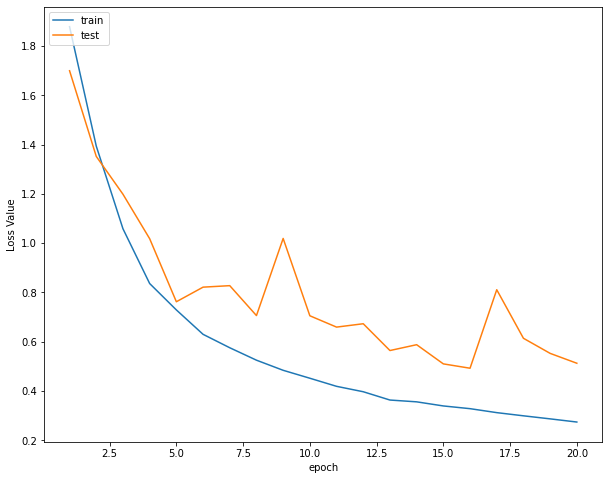

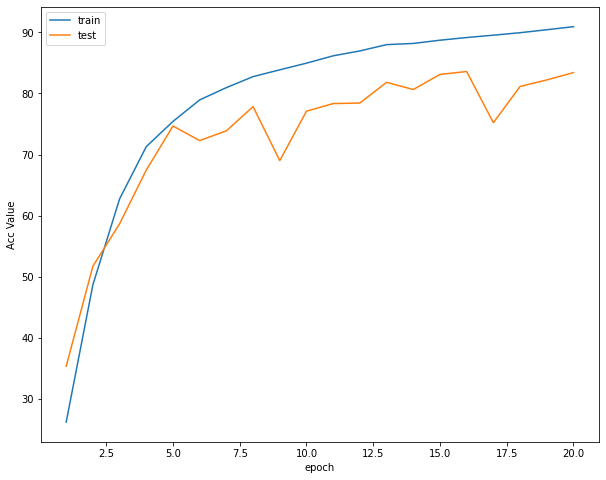

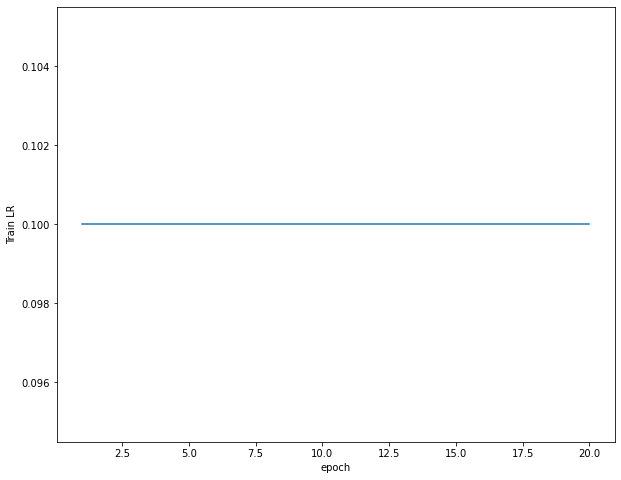

In [ ]:
plot_history(epoch ,Acc, Loss, Lr)

### 7.测试

In [ ]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=0)
net.eval()
for data in testloader:  # 循环每一个batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval()  # 把模型转为test模式
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images)  # 输入网络进行测试
    
    # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)          # 更新测试图片的数量
    correct += (predicted == labels).sum() # 更新正确分类的图片的数量

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
 

Accuracy of the network on the 10000 test images: 83.57 %


In [ ]:
 # 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 75.60 %
Accuracy of automobile : 93.90 %
Accuracy of  bird : 81.50 %
Accuracy of   cat : 75.90 %
Accuracy of  deer : 89.70 %
Accuracy of   dog : 80.40 %
Accuracy of  frog : 83.00 %
Accuracy of horse : 83.10 %
Accuracy of  ship : 92.10 %
Accuracy of truck : 81.30 %


Accuracy Rate = 81.25%


<Figure size 1800x288 with 0 Axes>

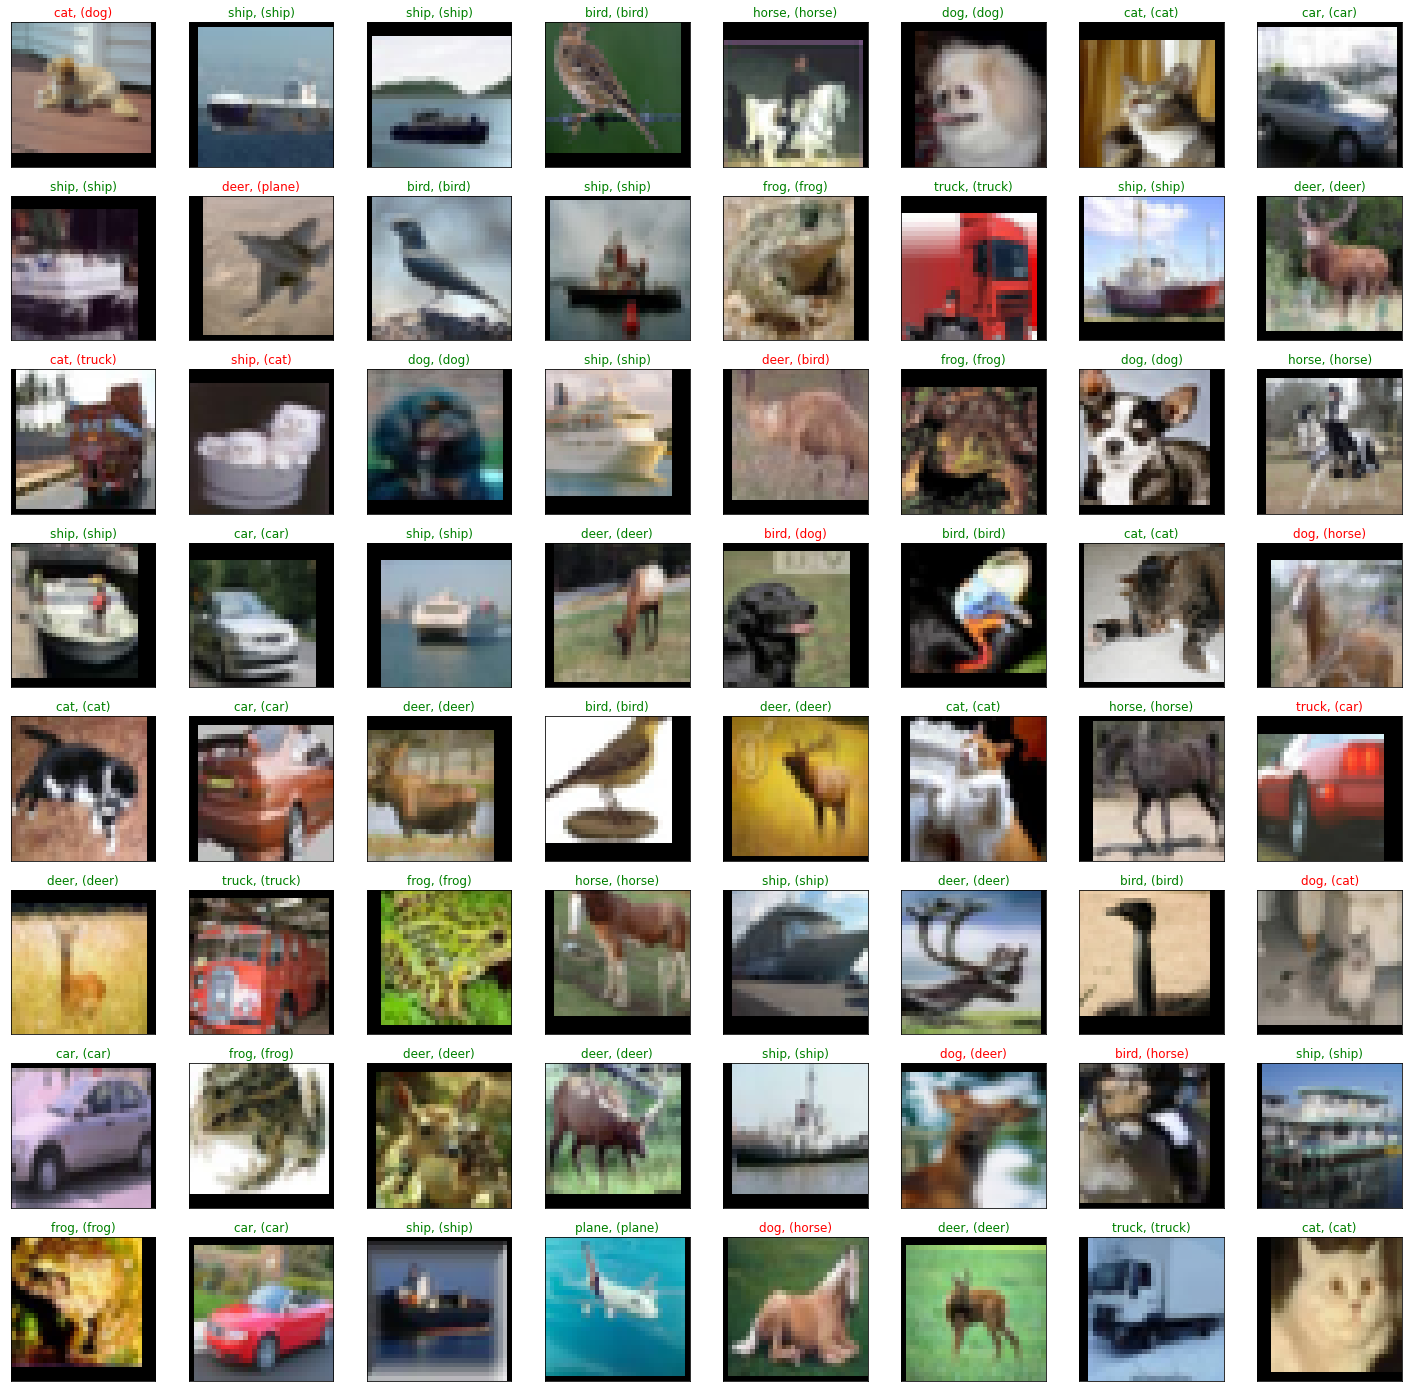

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

### 8. 保存模型

In [ ]:
torch.save(net,save_path[:-4]+str(epoch)+'.pth')
# torch.save(net, './model/VGG16-256.pth')

### 9. 预测

In [ ]:
import torch
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGG('VGG16')

model = torch.load(save_path)  # 加载模型
# model = model.to('cuda')
model.eval()  # 把模型转为test模式

# 读取要预测的图片
img = Image.open("./airplane.jpg").convert('RGB') # 读取图像

In [ ]:
img

In [ ]:
trans = transforms.Compose([transforms.Scale((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

<Response [200]>


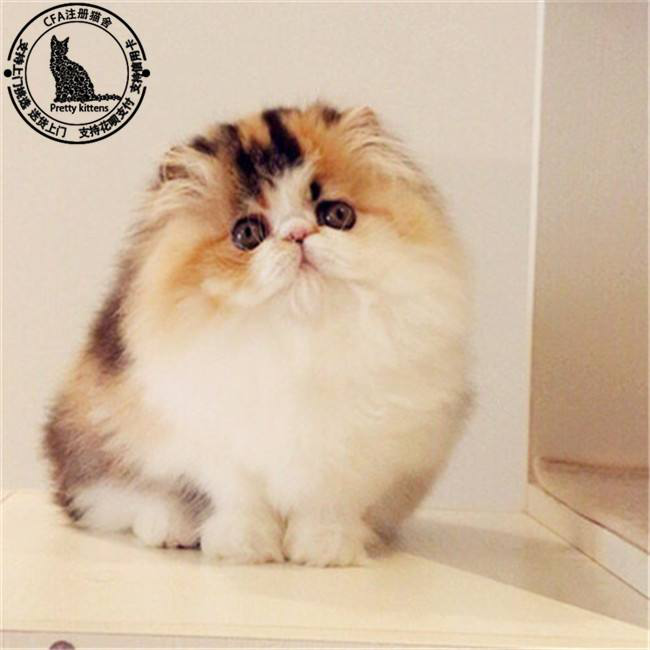

In [ ]:
import requests
from PIL import Image
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2952045457,215279295&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2838383012,1815030248&fm=26&gp=0.jpg'
url = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.goupuzi.com%2Fnewatt%2FMon_1809%2F1_179223_7463b117c8a2c76.jpg&refer=http%3A%2F%2Fwww.goupuzi.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1624346733&t=36ba18326a1e010737f530976201326d'
# url = 'https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2799543344,3604342295&fm=224&gp=0.jpg'
# url = 'https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2032505694,2851387785&fm=26&gp=0.jpg'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
img

In [ ]:
trans = transforms.Compose([transforms.Scale((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[4.0154e-05, 6.3702e-05, 3.9235e-03, 2.0309e-02, 3.0866e-04, 9.7383e-01,
         9.7511e-04, 5.3248e-04, 8.2619e-06, 1.1620e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
类别 5
tensor([7.4530], device='cuda:0')
分类 dog


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
